In [ ]:
# https://medium.com/@innohgicheru/a-step-by-step-guide-to-implement-shap-in-python-for-xai-and-machine-learning-5c32df5a70b5
# A Step-by-Step Guide to Implement SHAP in Python for XAI and Machine Learning
# Innocent Gicheru Wambui Apr 19, 2024

# Install SHAP, LIME, and scikit-learn
%pip install shap
%pip install lime
%pip install scikit-learn

In [ ]:
# Importing scikit-learn for machine learning tools
from sklearn import datasets
from sklearn import model_selection

# Loading the California house prices dataset since original Boston dataset is deprecated
california = datasets.fetch_california_housing()

# Splitting the dataset into training and testing sets (default is 75% train, 25% test)
X_train, X_test, y_train, y_test = model_selection.train_test_split(california.data, california.target, random_state=0)


In [ ]:
# *** Pythonic way to display feature importances ***

# Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Example: X, y = <your housing feature matrix and target>
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

model = LinearRegression()
model.fit(X_scaled, y_train)

importance_df = pd.DataFrame({
    'Feature': california.feature_names,
    'Importance': model.coef_
})

# Sort by absolute importance (descending)
lin_importance_df = importance_df.reindex(importance_df['Importance'].abs().sort_values(ascending=False).index)


In [ ]:
# Create and train the RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

regressor.fit(X_train, y_train)
print('Train R^2:', regressor.score(X_train, y_train))
print('Test  R^2:', regressor.score(X_test, y_test))


Train R^2: 0.9730976392461814
Test  R^2: 0.793966698716907


In [24]:
print("\n~~~ Feature Importances simple way (using sklearn modules) ~~~")
# I. Print linear regression feature importances from sklearn.linear_model.LinearRegression().coef_
print("\nLinear regression (= fitted coefficients):")
print('\n'.join(f"{row['Feature']}: {row['Importance']: .3f}" for _, row in lin_importance_df.iterrows()))

# II. Print importances from the trained sklearn.ensemble.RandomForestRegressor.feature_importances_
feature_names = california.feature_names
importances = regressor.feature_importances_
features_and_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
print('\nMean decrease in impurity (MDI):')
for name, imp in features_and_importances:
    print(f"{name}: {imp:.3f}")

# III. Print feature names and their permutation importances from sklearn.inspection.permutation_importance
print("\nPermutation:")
# Compute permutation importance once per kernel session to avoid duplicate prints
from sklearn.inspection import permutation_importance
perm = permutation_importance(regressor, X_test, y_test, n_repeats=30, random_state=0, scoring='r2')
perm_summary = {name: (mean, std) for name, mean, std in zip(feature_names, perm.importances_mean, perm.importances_std)}
for name, (mean, std) in sorted(perm_summary.items(), key=lambda x: x[1][0], reverse=True):
    #print(f"{name}: mean={mean:.3f}, std={std:.3f}")
    print(f"{name}: {mean:.3f}")



~~~ Feature Importances simple way (using sklearn modules) ~~~

Linear regression (= fitted coefficients):
Latitude: -0.892
Longitude: -0.864
MedInc:  0.832
AveBedrms:  0.304
AveRooms: -0.262
HouseAge:  0.121
AveOccup: -0.030
Population: -0.009

Mean decrease in impurity (MDI):
MedInc: 0.530
AveOccup: 0.137
Longitude: 0.084
Latitude: 0.084
HouseAge: 0.057
AveRooms: 0.047
Population: 0.031
AveBedrms: 0.031

Permutation:
MedInc: 0.786
Latitude: 0.414
Longitude: 0.310
AveOccup: 0.200
HouseAge: 0.073
AveRooms: 0.030
Population: 0.009
AveBedrms: 0.008


In [8]:
# Helper cell:
# prints feature name to index mapping and provides lookup utility
# Run this cell to see the column index for each feature name. Use the
# integer index in matplotlib scatter or numeric SHAP arrays when needed.

for idx, name in enumerate(feature_names):
    print(f"{idx}: {name}")


def feature_index(name: str) -> int:
    """Return the integer column index for a given feature name.

    Raises ValueError if the name is not found.
    """
    try:
        return feature_names.index(name)
    except ValueError:
        raise ValueError(f"Feature name {name!r} not found. Available names: {feature_names}")

# Example usage:
try:
    print("\nExample: index of 'HouseAge' ->", feature_index('HouseAge'))
except ValueError:
    print("Feature 'HouseAge' not present in feature_names")



0: MedInc
1: HouseAge
2: AveRooms
3: AveBedrms
4: Population
5: AveOccup
6: Latitude
7: Longitude

Example: index of 'HouseAge' -> 1


In [ ]:
# Now try with SHAP

import shap

explainer = shap.TreeExplainer(regressor, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)


100%|===================| 5150/5160 [05:19<00:00]        

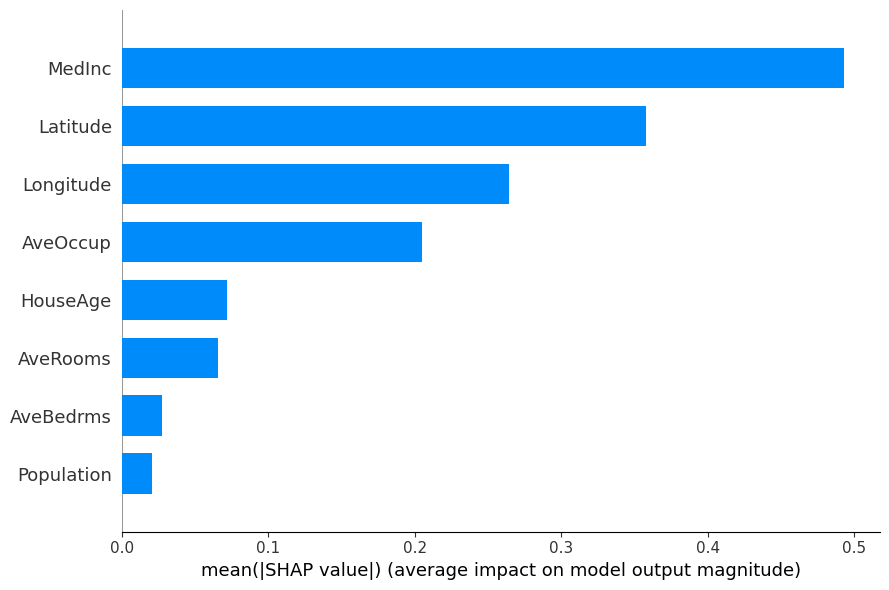

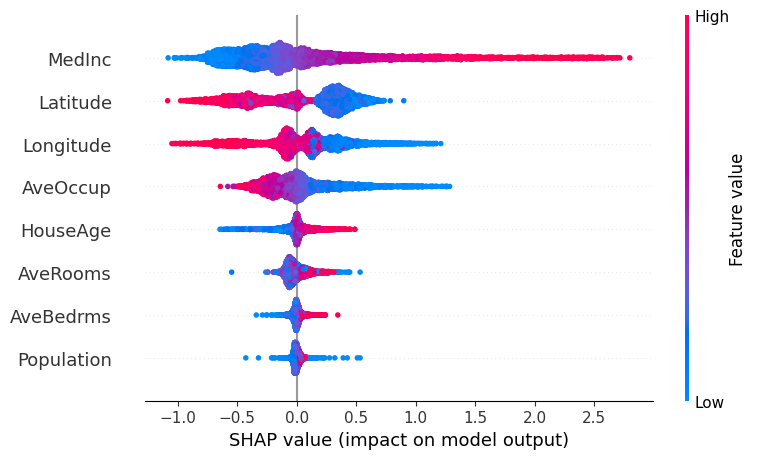

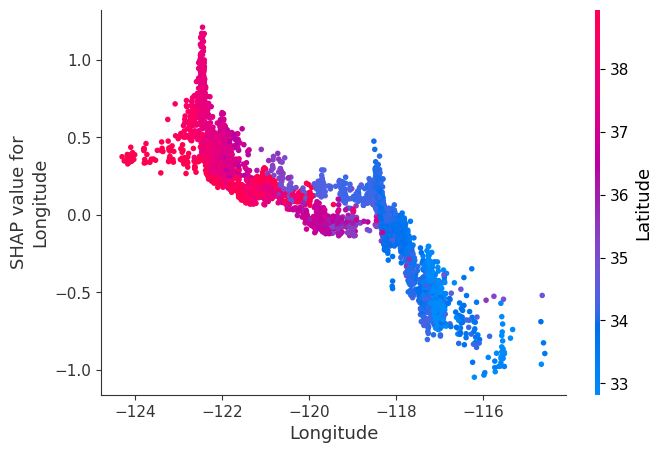

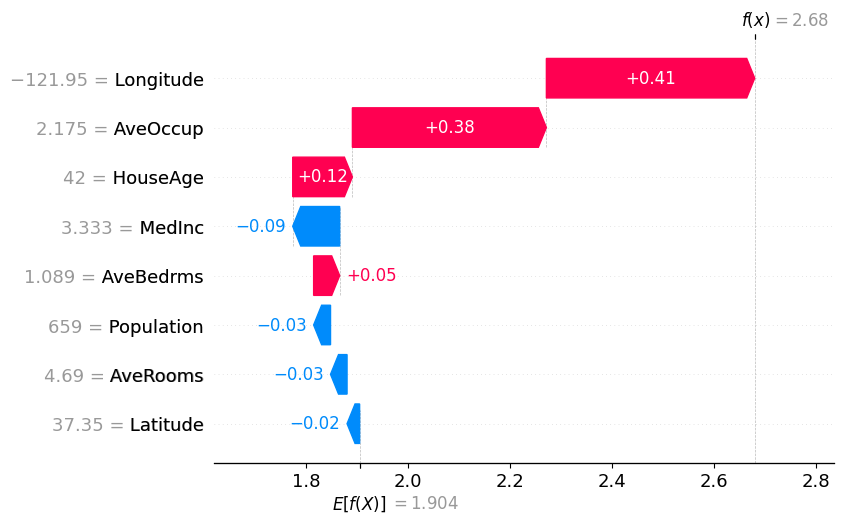

In [ ]:
# Plot summary (alternate/earlier block)
# This cell contains several SHAP visualizations. Comments above each call
# explain what the plot shows, what inputs it uses, and notes about
# interactivity/fallback behavior.

import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric SHAP array for legacy plotting functions. 
shap_values_plot = np.array(shap_values)

# ---------------------------------------------------------------------------
# 1) Summary plot (bar)
#    - Shows the mean absolute SHAP value per feature (global importance, not individual).
#    - No indication of directionality (increase or decrease in value/probability of positive prediction).
#    - Inputs: numeric SHAP array (n_samples, n_features), X_test, feature_names.
#    - Use for a compact importance ranking; no JS required.
# ---------------------------------------------------------------------------
shap.summary_plot(shap_values_plot, X_test, feature_names=feature_names, plot_type="bar",
                  title="Test", plot_size=(9,6))

# ---------------------------------------------------------------------------
# 2) Summary plot (dot)
#    - Shows distribution of SHAP values per feature (one dot per sample).
#    - Color encodes feature value; reveals directionality and spread.
# ---------------------------------------------------------------------------
shap.summary_plot(shap_values_plot, X_test, feature_names=feature_names)

# ---------------------------------------------------------------------------
# 3) Dependence plot for 'Longitude'
#    - Scatter of SHAP value for 'Longitude' vs the actual Longitude feature value.
#    - Useful to inspect how the contribution of Longitude changes with its value
#      and to observe interactions with other features.
# ---------------------------------------------------------------------------
shap.dependence_plot('Longitude', shap_values_plot, X_test, feature_names=feature_names)

# ---------------------------------------------------------------------------
# SHAP waterfall_plot requires an Explanation object, not a numpy array.
# We'll create an Explanation for a single sample(house) (e.g., i=10).
i = 10
waterfall_exp = shap.Explanation(
    values=shap_values_plot[i],
    base_values=explainer.expected_value,
    data=X_test[i],
    feature_names=feature_names
)
shap.waterfall_plot(waterfall_exp)

# ---------------------------------------------------------------------------
# 4) Force plot for one sample (interactive)
#    - Visualizes how each feature's SHAP value pushes the prediction from the
#      expected/base value to the model output for that sample.
#    - Legacy force_plot returns an HTML/JS object; run shap.initjs() to inject
#      required JS into the frontend. If JS is blocked, use shap.save_html(...)
#      to view in a browser.
# ---------------------------------------------------------------------------
shap.initjs()
# sample index to visualize
shap.force_plot(explainer.expected_value, shap_values_plot[i], X_test[i], feature_names=feature_names)




In [ ]:
# LIME Tabular explanation for sample i (re-uses i defined earlier in this notebook)
from lime.lime_tabular import LimeTabularExplainer

# Create the explainer using the training data and feature names
explainer_lime = LimeTabularExplainer(training_data=X_train, feature_names=feature_names, mode='regression')

# Explain the prediction for the sample index i (should be defined earlier as i = 10)
exp = explainer_lime.explain_instance(X_test[i], regressor.predict, num_features=10)

# Print a simple textual summary (feature, weight)
print("LIME explanation (feature, weight):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Display the interactive HTML explanation inside the notebook (if supported)
from IPython.display import HTML, display
display(HTML(exp.as_html()))

# To see meaning of "..." on the plot, save it as HTML, open in the browser and examine page source (right-click...)
html = exp.as_html()
with open('lime_expl_i10.html', 'w', encoding='utf8') as f:
    f.write(html)
# open it in the browser: file:///C:/Users/n2703/Documents/BeCodeAIMay2025/talks/XAI/XAI_DemoCode/shapRF_CaliforniaPrices/lime_expl_i10.html

LIME explanation (feature, weight):
Longitude <= -121.80: 0.5716
2.57 < MedInc <= 3.55: -0.5387
AveOccup <= 2.43: 0.5063
34.25 < Latitude <= 37.71: -0.2189
HouseAge > 37.00: 0.1388
4.45 < AveRooms <= 5.23: -0.0517
Population <= 785.00: -0.0210
1.05 < AveBedrms <= 1.10: -0.0097


Top Pearson absolute correlations (feature pair: r):
Latitude - Longitude: -0.925
AveRooms - AveBedrms: 0.848
MedInc - AveRooms: 0.327
HouseAge - Population: -0.296
HouseAge - AveRooms: -0.153
MedInc - HouseAge: -0.119
Population - Latitude: -0.109
HouseAge - Longitude: -0.108
AveRooms - Latitude: 0.106
Population - Longitude: 0.100
Top Spearman absolute correlations (feature pair: rho):
Latitude - Longitude: -0.879
MedInc - AveRooms: 0.644
HouseAge - Population: -0.284
MedInc - AveBedrms: -0.252
Population - AveOccup: 0.242
HouseAge - AveRooms: -0.231
AveOccup - Longitude: 0.181
AveOccup - Latitude: -0.151
HouseAge - Longitude: -0.151
MedInc - HouseAge: -0.147


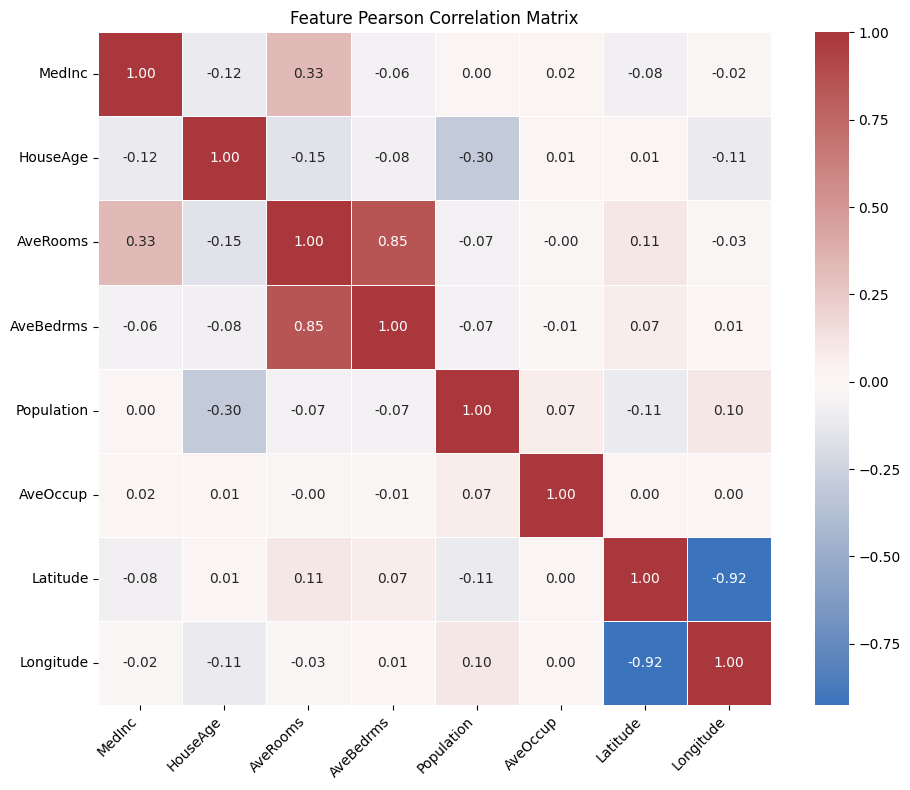

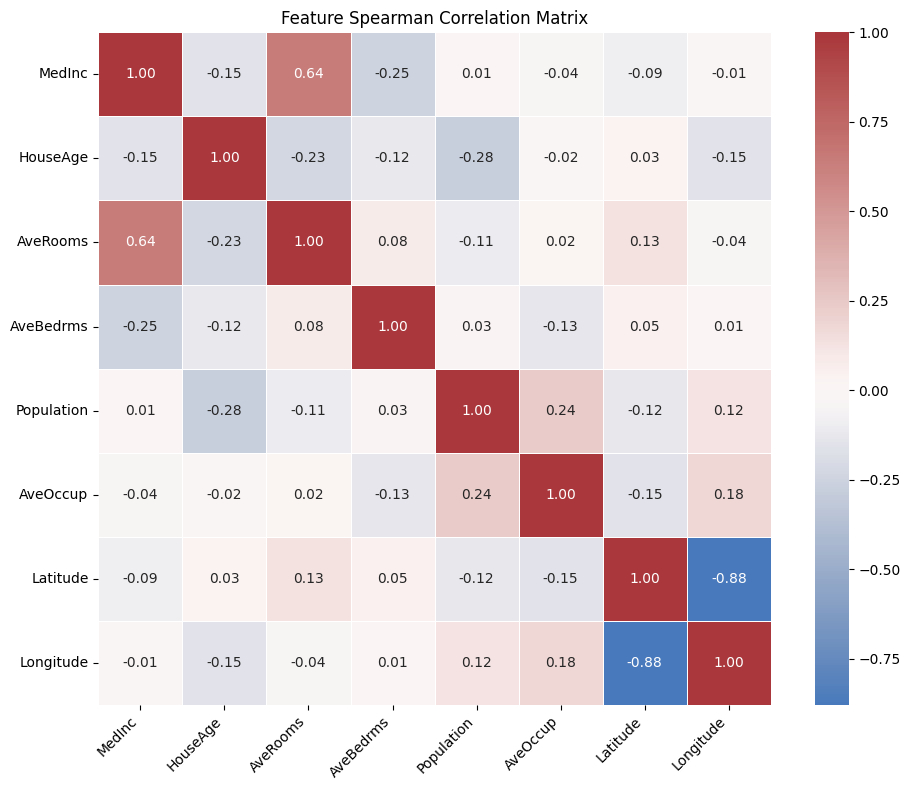

In [23]:
# Correlation metrics between features (Pearson + Spearman)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Build a DataFrame from the full dataset (use training+test or just training as desired)
# Here we use the original california.data with feature_names provided
df = pd.DataFrame(california.data, columns=feature_names)

# Compute Pearson and Spearman correlation matrices
pearson = df.corr(method='pearson')
spearman = df.corr(method='spearman')

# Print top absolute correlations (excluding self-correlations) for Pearson
def top_pairs(corr_df, top_n=10):
    pairs = []
    for a, b in combinations(corr_df.columns, 2):
        pairs.append(((a, b), corr_df.loc[a, b]))
    pairs_sorted = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    return pairs_sorted[:top_n]

print("Top Pearson absolute correlations (feature pair: r):")
for (a_b, r) in top_pairs(pearson, top_n=10):
    (a, b) = a_b
    print(f"{a} - {b}: {r:.3f}")

print("Top Spearman absolute correlations (feature pair: rho):")
for (a_b, r) in top_pairs(spearman, top_n=10):
    (a, b) = a_b
    print(f"{a} - {b}: {r:.3f}")

# Plot a heatmap for Pearson correlations with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(pearson, annot=True, fmt=".2f", cmap="vlag", center=0, square=True, linewidths=.5)
plt.title("Feature Pearson Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optionally also show Spearman heatmap (uncomment to enable)
plt.figure(figsize=(10,8))
sns.heatmap(spearman, annot=True, fmt=".2f", cmap="vlag", center=0, square=True, linewidths=.5)
plt.title("Feature Spearman Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()